In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
import pandas as pd
import numpy as np
from darts import TimeSeries
    
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('el_price.csv', sep = ';')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])
    
# Interpolate missing values in the 'price' column using linear method
df_el['price'].interpolate(method='linear', inplace=True)

ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=True, freq=None)

In [5]:
# we prepare data for linear model. 

df_el['time'] = np.arange(len(df_el.index))
df_el.set_index('date', inplace=True)

C:\Users\dicod\AppData\Local\Temp\ipykernel_13912\225437666.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


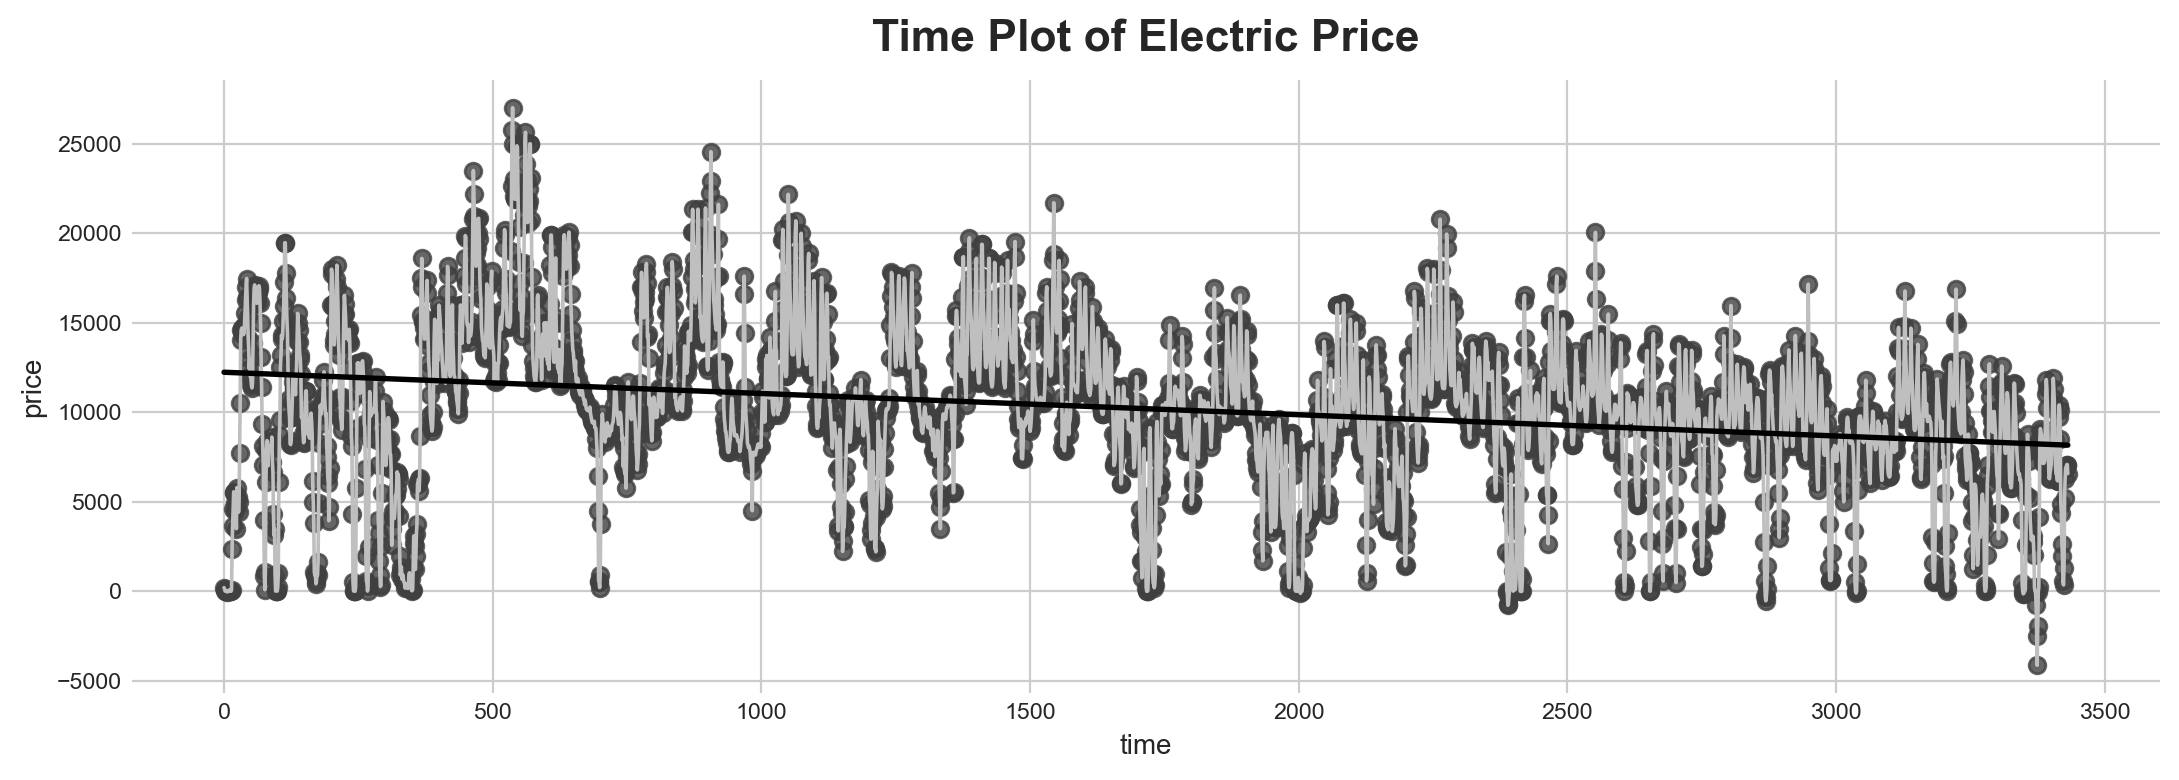

In [6]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('time', 'price', data=df_el, color='0.75')
ax = sns.regplot(x='time', y='price', data=df_el, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Electric Price');

In [25]:
# Lag features¶
# To make a lag feature we shift the observations of the target series so that they appear to have occured later in time.
# Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.
df_el['Lag_24h'] = df_el['price'].shift(24)
df_el_lag = df_el.reindex(columns=['price', 'Lag_24h'])

#### Why we use lag in timeseries data?

Time series analysis uses lags because the value of a time series at a given point in time can be dependent on the values of the series at previous points in time. In other words, the behavior of a time series at time t can be influenced by its values at times t-1, t-2, and so on.

A lag is simply a time shift of a time series by a certain number of time periods. For example, the first-order lag of a time series at time t is its value at time t-1. By analyzing the relationship between a time series and its lagged values, we can identify patterns, trends, and other characteristics of the series.

Lagging a time series can be useful for a variety of purposes in time series analysis, such as:

Prediction: By using lagged values of a time series as input features, we can build models to forecast future values of the series.

Autocorrelation analysis: Lagging a time series allows us to calculate its autocorrelation function (ACF), which measures the correlation between the series and its lagged values. The ACF can be used to identify the presence of trends, seasonal patterns, and other forms of correlation in the series.

Stationarity testing: A stationary time series is one whose statistical properties (such as mean and variance) do not change over time. By lagging a time series and calculating its ACF, we can test whether the series is stationary or not.

Overall, lags play an important role in time series analysis by allowing us to analyze the temporal dependencies between a series and its past values, and to extract useful information for forecasting and analysis.

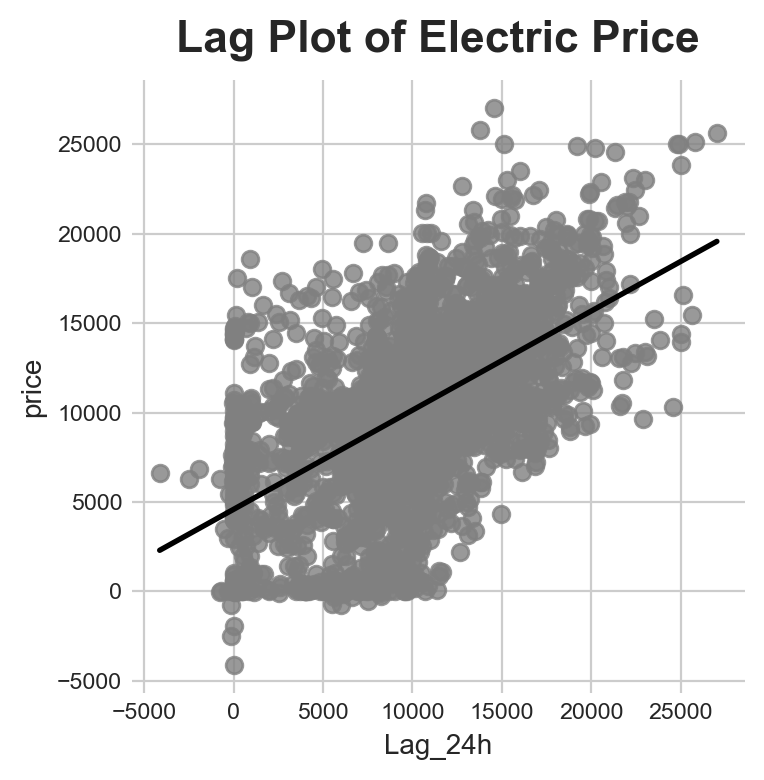

In [12]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_24h', y='price', data=df_el, ci=None, scatter_kws=dict(color='0.5'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Electric Price');

Text(0.5, 1.0, 'Time Plot of Electric Price_Linear Prediction')

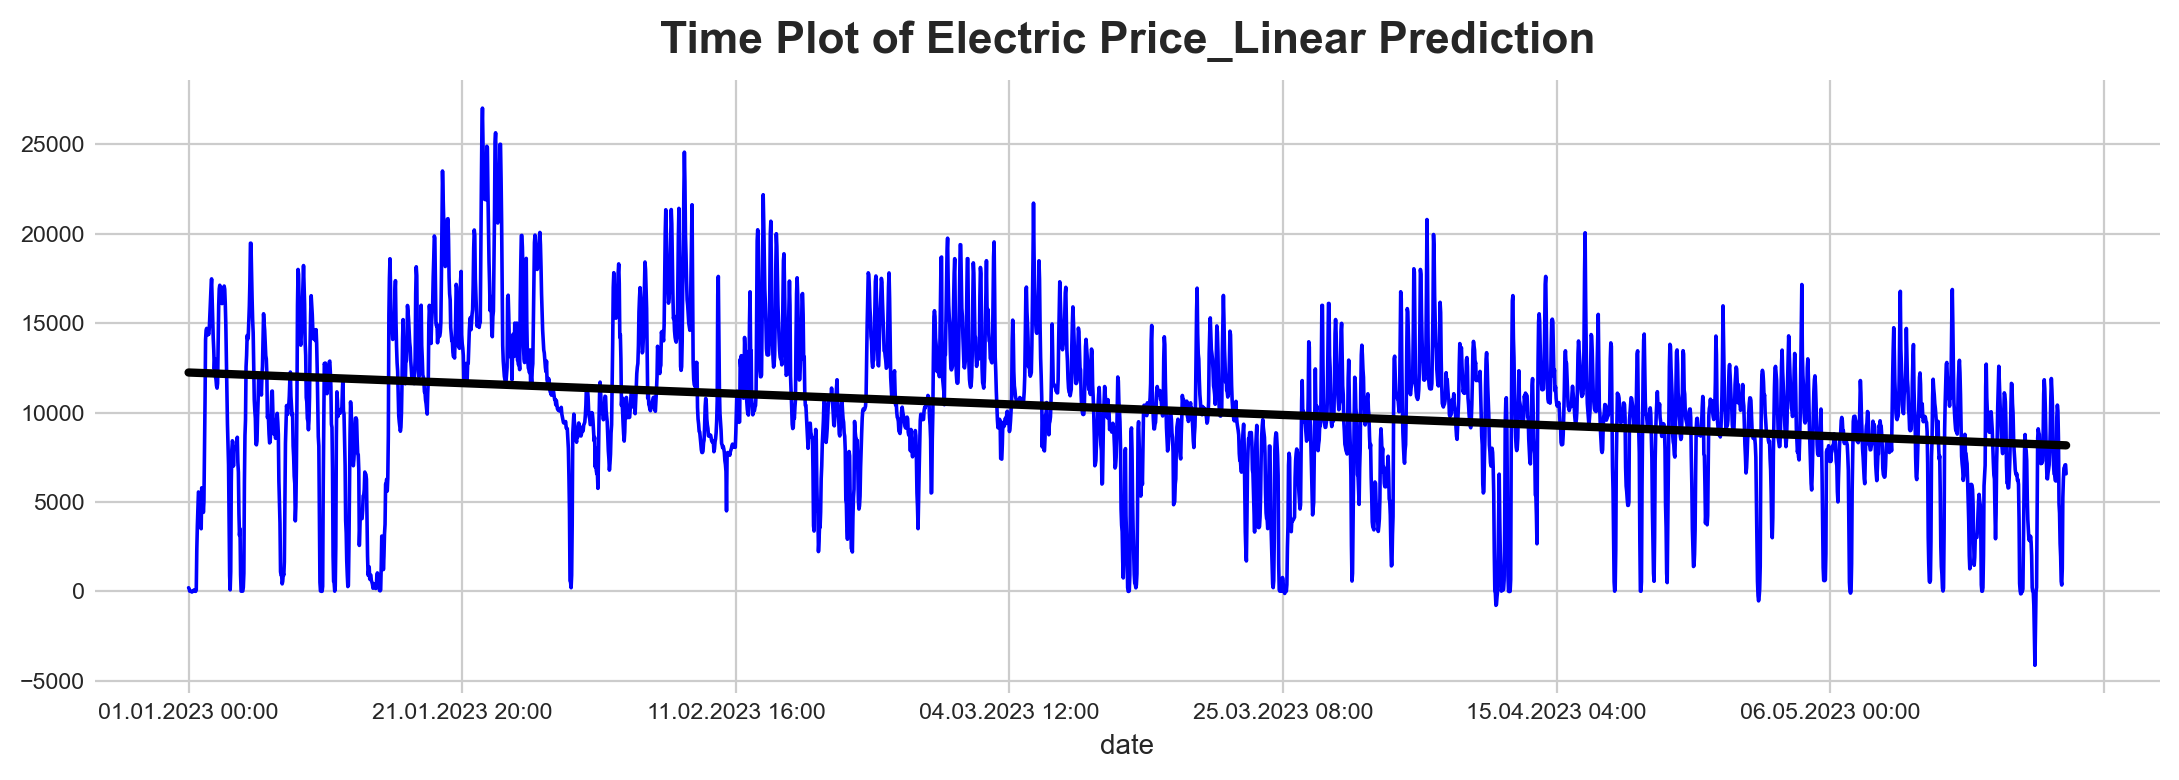

In [13]:
# Training data
X = df_el.loc[:, ['time']]  # features
y = df_el.loc[:, 'price']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

plot_params = {'color': 'blue', 'linestyle': '-'}

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Electric Price_Linear Prediction')

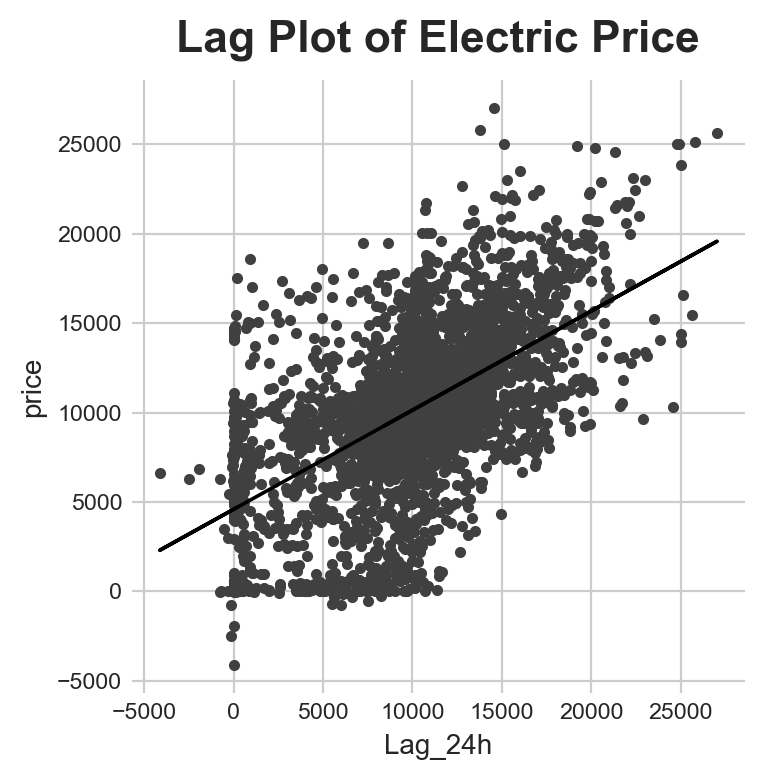

In [14]:
X = df_el.loc[:, ['Lag_24h']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_el.loc[:, 'price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag_24h'], y, '.', color='0.25')
ax.plot(X['Lag_24h'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('price')
ax.set_xlabel('Lag_24h')
ax.set_title('Lag Plot of Electric Price');

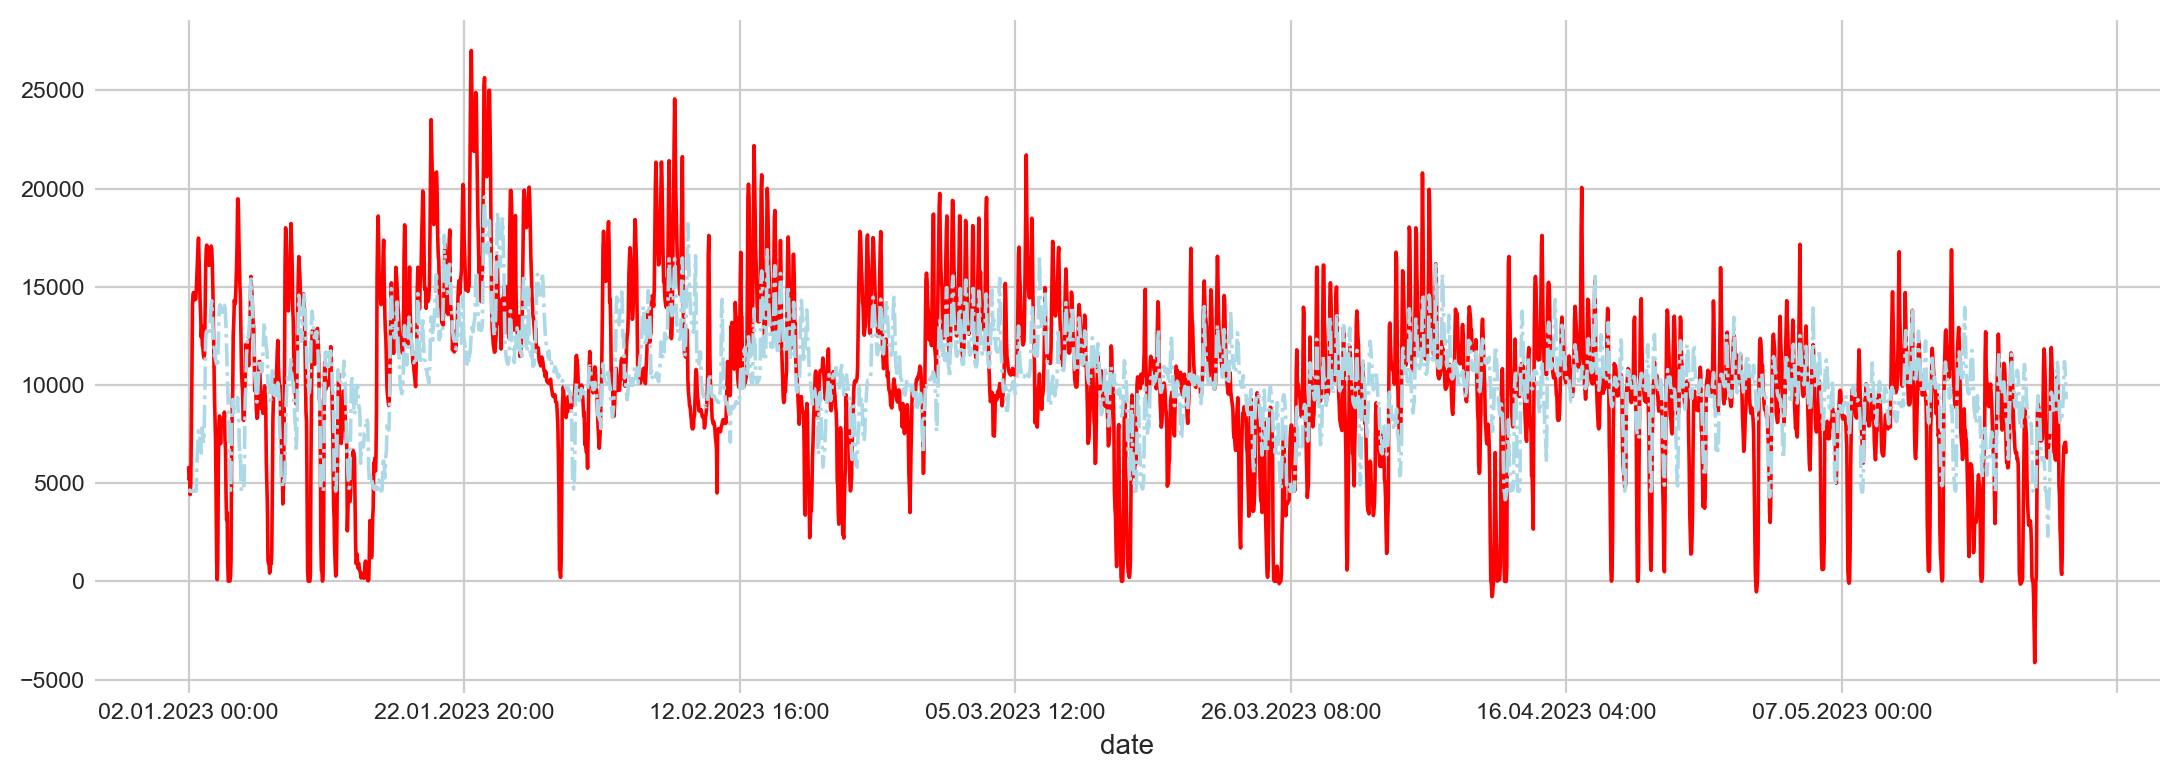

In [15]:
plot_params_actu = {'color': 'red', 'linestyle': '-'}
plot_params_pred = {'color': 'lightblue', 'linestyle': 'dashdot'}

ax = y.plot(**plot_params_actu)
ax = y_pred.plot(**plot_params_pred)

In [16]:
squared_diff = (y_pred - y) ** 2
    
# Calculate the mean squared error
mse = np.mean(squared_diff)
rmse = np.sqrt(mse)

print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 3599.3257847695086


In [23]:
y_pred[-24:]

date
23.05.2023 00:00     8642.936287
23.05.2023 01:00     8546.472429
23.05.2023 02:00     8598.030698
23.05.2023 03:00     8569.756809
23.05.2023 04:00     8635.174827
23.05.2023 05:00     9396.352284
23.05.2023 06:00    10701.386320
23.05.2023 07:00    11147.670262
23.05.2023 08:00    10876.573557
23.05.2023 09:00    10260.646278
23.05.2023 10:00     9410.212033
23.05.2023 11:00     8655.687257
23.05.2023 12:00     8085.219957
23.05.2023 13:00     8074.132157
23.05.2023 14:00     8268.723044
23.05.2023 15:00     8372.393972
23.05.2023 16:00     8513.763420
23.05.2023 17:00     8951.731512
23.05.2023 18:00     9578.192200
23.05.2023 19:00    10576.648572
23.05.2023 20:00    11185.923171
23.05.2023 21:00    10842.201377
23.05.2023 22:00    10367.643546
23.05.2023 23:00     9272.168926
dtype: float64

In [26]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('el_price.csv', sep = ';')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])
    
# Interpolate missing values in the 'price' column using linear method
df_el['price'].interpolate(method='linear', inplace=True)

ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=True, freq=None)


# training
train, test = ts.split_after(pd.Timestamp("01.05.2023 00:00"))

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(ts)

model = RegressionModel(lags=24, model=BayesianRidge()) 

model.fit(train_scaled)

pred = model.predict(train_scaled)

# scale back:
pred = scaler.inverse_transform(pred)

plt.figure(figsize=(10, 6))
ts.plot(label="actual (el_price)")
pred.plot(label="forecast (el_price)")

TypeError: 'TimeSeries' object cannot be interpreted as an integer

In [15]:
# we have an issue, mape evluation function, it does not support negative and 0 values... 

from darts.metrics import mape
from darts.metrics import rmse
# mape (ts, pred)
rmse(ts, pred)

81.44736296295595

## A less naive model

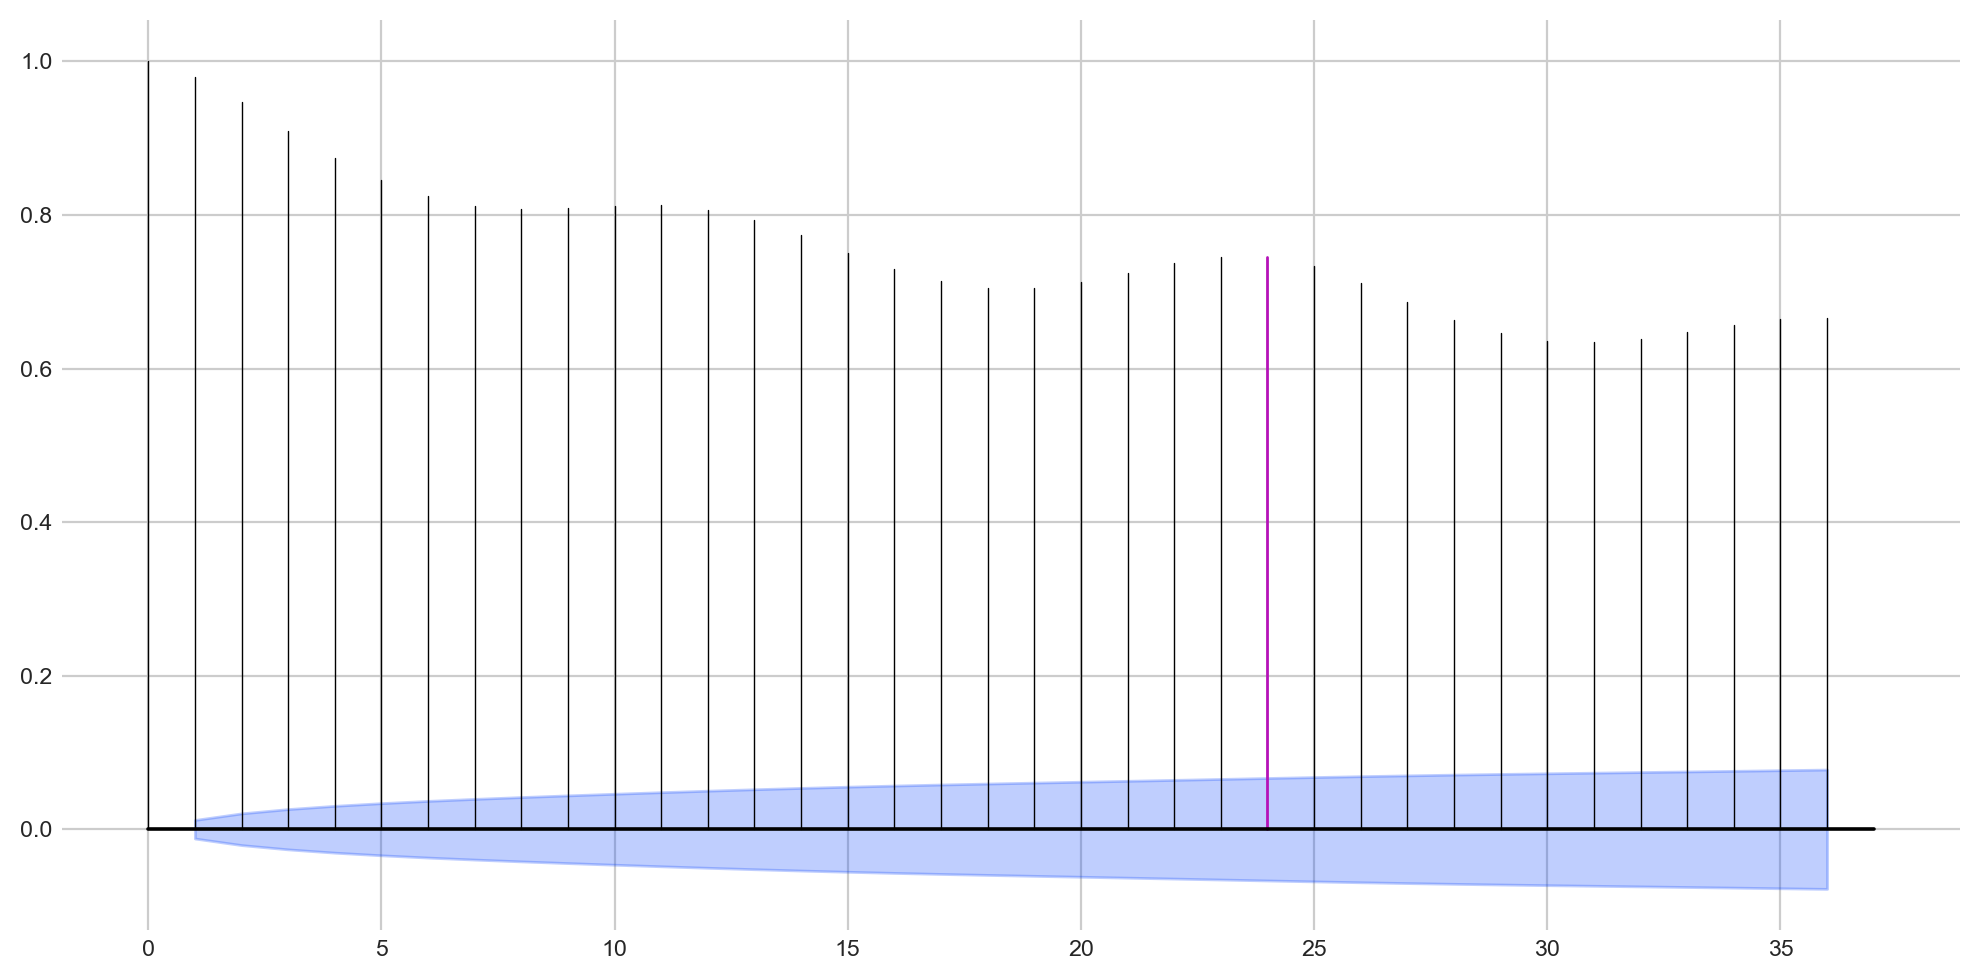

In [16]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=24, max_lag = 36, alpha=0.05)

for m in range(2, 36):
    is_seasonal, period = check_seasonality(train, m=24, max_lag = 12, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

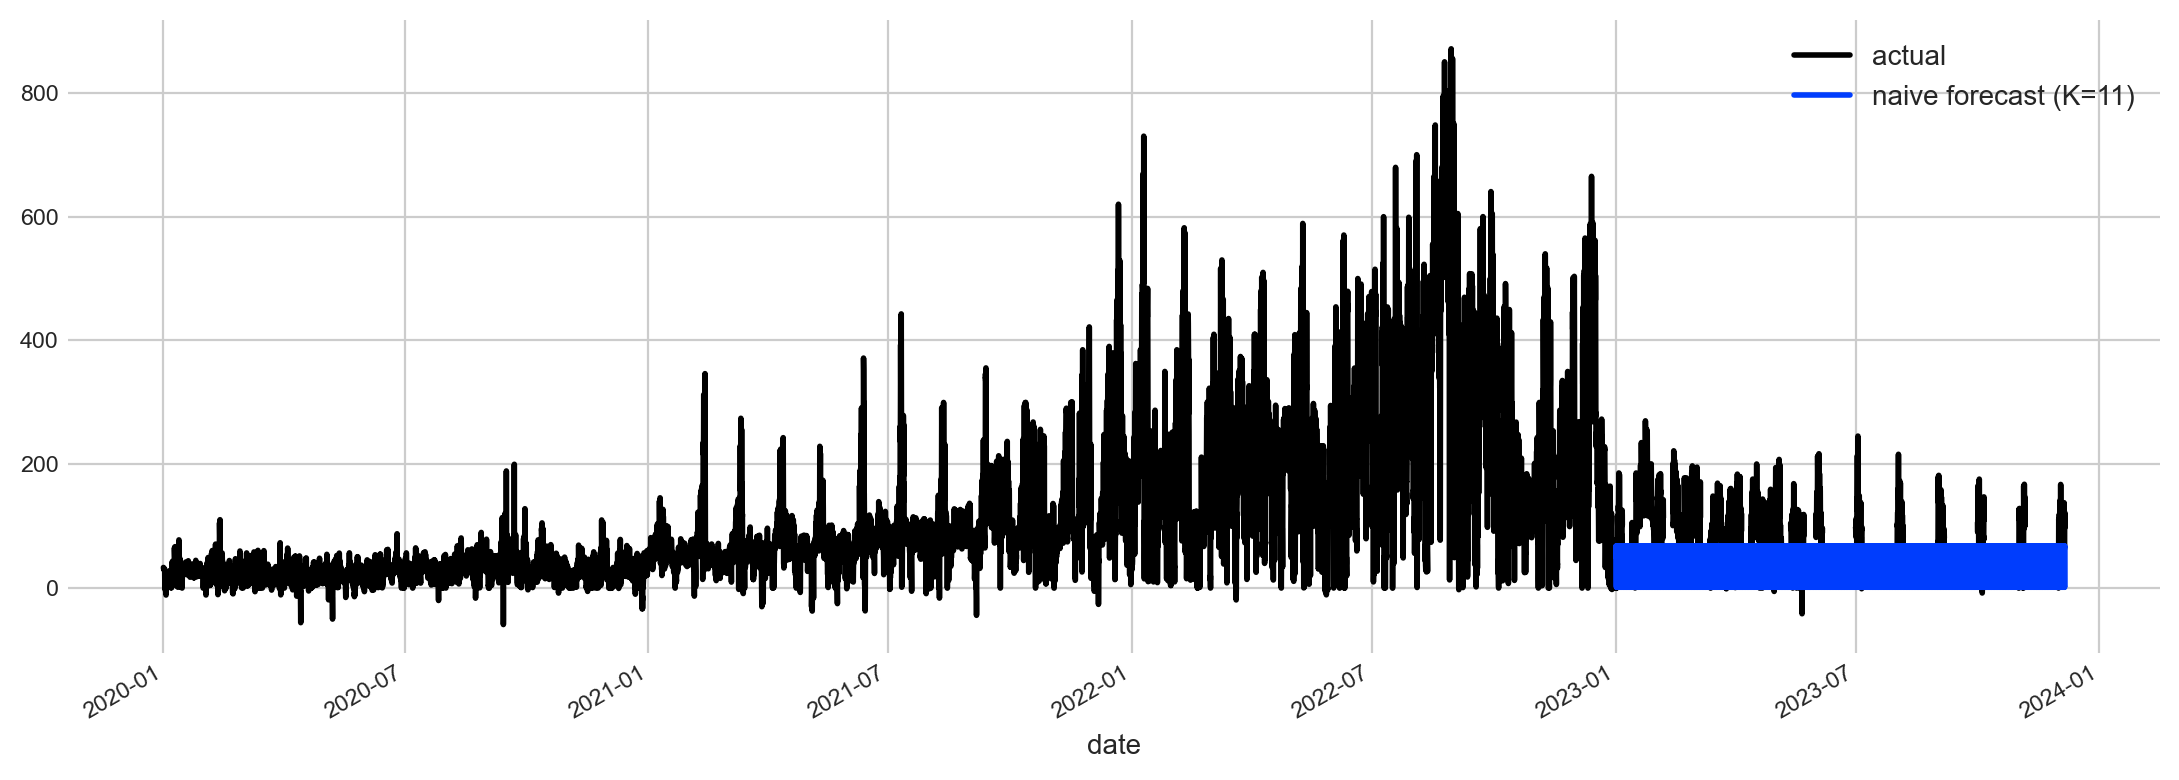

In [17]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=11)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test_scaled))

ts.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=11)")

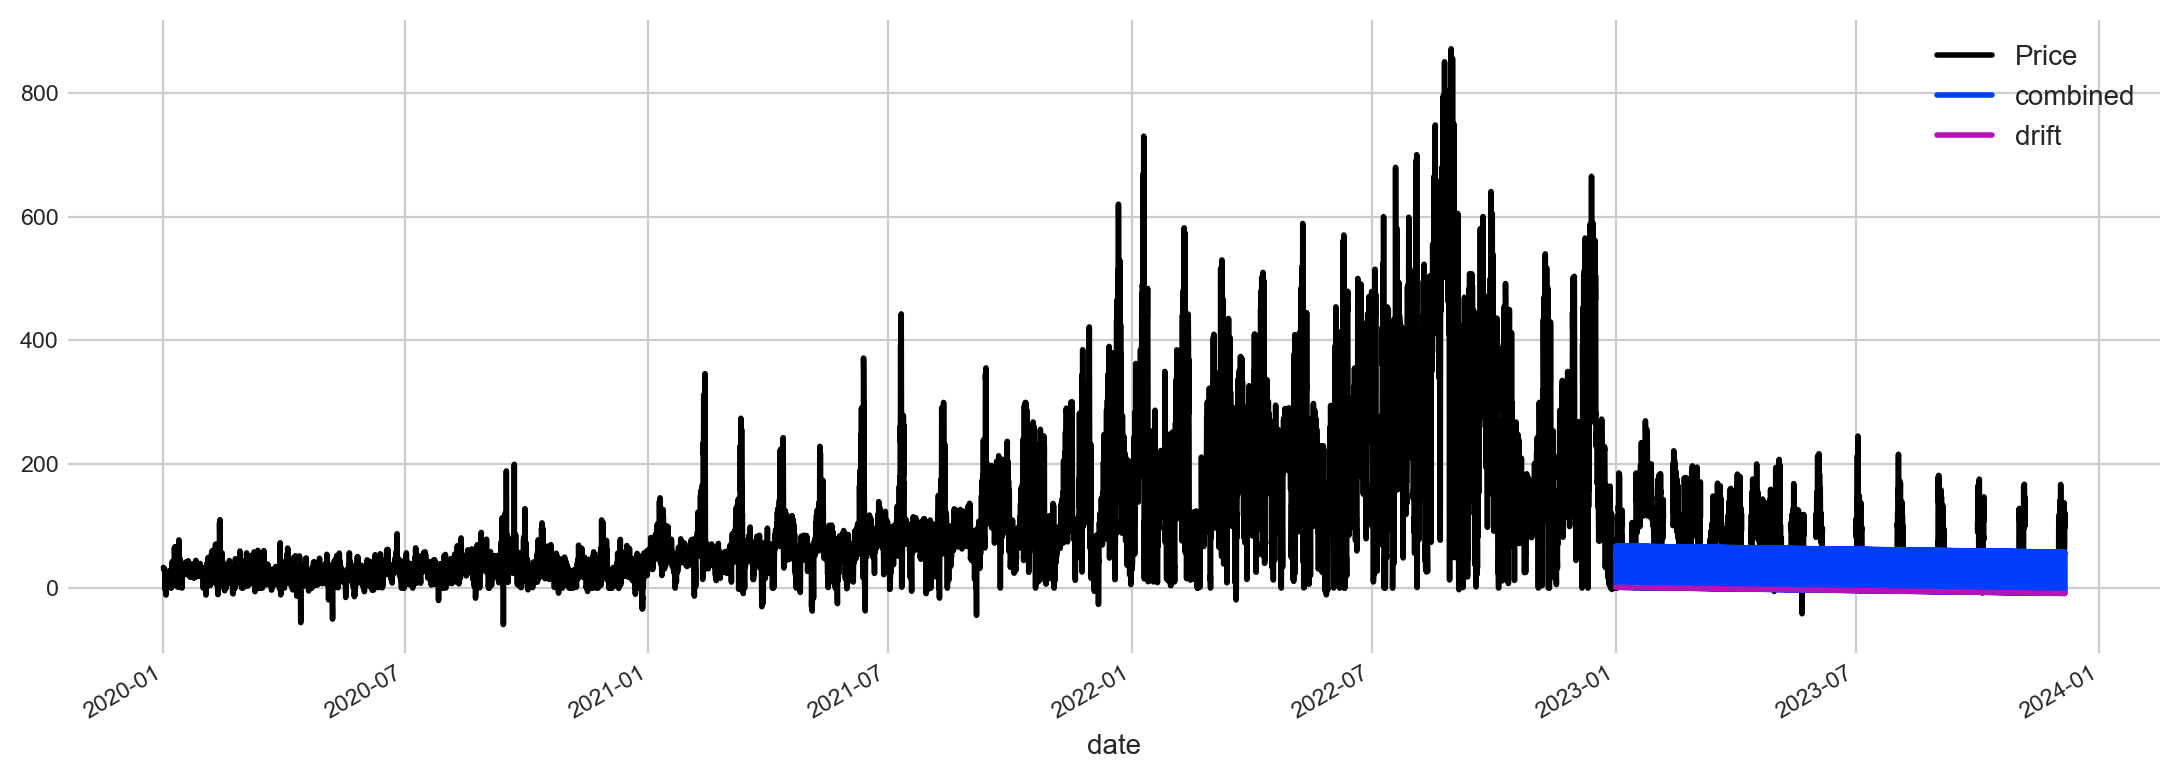

In [18]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test_scaled))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

ts.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [19]:
# oh my god!

from darts.metrics import rmse

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        rmse(ts, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 87.09%.


In [3]:
# it takes long time, I stop working

from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(ts))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(ts, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
# eval_model(Theta())

NameError: name 'train' is not defined

In [20]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    ts, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("RMSE = {:.2f}%".format(rmse(historical_fcast_es, ts)))

  0%|          | 0/13775 [00:00<?, ?it/s]

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

KeyboardInterrupt: 